In [1]:
import numpy as np
import pandas as pd
import calc_rates
import fit_model
import rpy2
%load_ext rpy2.ipython
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.transforms
import matplotlib.lines
import seaborn
import scipy.integrate
import scipy.optimize
import scipy.stats
import importlib
import multiprocessing
import itertools
import logging
import pickle
import collections
import color_scheme
# import numpy.random
import os

plt.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = (
    r"\usepackage{amsmath}" 
    + r"\usepackage{siunitx}" 
    + r"\usepackage{lmodern}" 
    + r"\input{" + f"{os.path.abspath('../data/00_abbrevs.tex')}" + r"}"
    + r"\sisetup{detect-all}"
    + r"\usepackage{sansmathfonts}"
)


logging.basicConfig(level=logging.WARNING)

fig_path = "../figs/"
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["font.size"] = 14
# plt.rcParams["font.family"] = "sans-serif"

During startup - Warning messages:
1: Setting LC_TIME failed, using "C" 
2: Setting LC_MONETARY failed, using "C" 
3: Setting LC_PAPER failed, using "C" 
4: Setting LC_MEASUREMENT failed, using "C" 


In [2]:
data_dir = "../data/"


# the 2 function are necessary to load defaultdict from pickeled objects
def dict_list():
    return collections.defaultdict(list)


def dict_dict():
    return collections.defaultdict(dict)


with open(f"{data_dir}spline_dfs.pickle", "rb") as f:
    spline_dfs = pickle.load(f)

with open(f"{data_dir}spline_functions.pickle", "rb") as f:
    f_spline = pickle.load(f)

with open("../data/data_df.pickle", "rb") as f:
    data_df = pickle.load(f)

with open("../data/c_feed.pickle", "rb") as f:
    c_feed = pickle.load(f)

df_spline = spline_dfs[7]
df_spline["Gi"] = df_spline.G

Y_XG = 0.627
Y_PG = 0.652

In [3]:
def get_param(df, dependence, target="g"):
    def get_ode(dep, res, target):
        d = list(dependence)
        r = res.copy()
        if target == "g":
            if "G" not in [var_name for var_name, _, _ in dep]:
                d.append(["G", fit_model.f_MM, [(1e-15, 1e2)]])
                r.append(["G", [1e-3], 0, 0, 0])
            ode = fit_model.OdeG(d, r)
        elif target == "gm":
            ode = fit_model.OdeGm(d, r)
        else:  # target == "gP"
            ode = fit_model.OdeGp(d, r)
        return ode

    res, df_var = fit_model.calc_var_table(dependence, df, target)
    ode = get_ode(dependence, res, target)
    variables = tuple([x[0] for x in dependence])
    error = df_var.variance.values[0]
    return ode, df_var, variables, error


def get_TSS(df, target="g"):
    errors = df[target] - df[target].mean
    return np.sum(errors**2), errors


class CvMulti:
    def __init__(self, target) -> None:
        self.target = target

    def f(self, x):
        model, df = x
        return get_param(df, model, self.target)


def cross_val(df, dependence, target="g"):
    def get_CV_error(ode, df, process, target):
        df_process = df[df.process == process].copy()
        if target == "g":
            df_process["est"] = [
                ode.f_g(G, n, P, X, T)
                for G, n, P, X, T in zip(
                    df_process.G,
                    df_process.n,
                    df_process.P,
                    df_process.X,
                    df_process["T"],
                )
            ]
            df_process["error"] = df_process.est - df_process.g
        elif target == "gm":
            df_process["est"] = [
                ode.f_gm(g, G, n, P, X, T)
                for g, G, n, P, X, T in zip(
                    df_process.g,
                    df_process.G,
                    df_process.n,
                    df_process.P,
                    df_process.X,
                    df_process["T"],
                )
            ]
            df_process["error"] = df_process.est - df_process.gm
        else:  # target == "gP"
            df_process["est"] = [
                ode.f_gP(g, gm, G, n, P, X, T)
                for g, gm, G, n, P, X, T in zip(
                    df_process.g,
                    df_process.gm,
                    df_process.G,
                    df_process.n,
                    df_process.P,
                    df_process.X,
                    df_process["T"],
                )
            ]
            df_process["error"] = df_process.est - df_process.gP

        return np.sum(df_process.error**2)

    all_models = list(
        itertools.chain.from_iterable(
            [itertools.combinations(dependence, i) for i in range(len(dependence) + 1)]
        )
    )
    vars = [tuple([x[0] for x in d]) for d in all_models]
    processes = df.process.unique()
    all_dfs = [df[df.process != p] for p in processes]

    multi = CvMulti(target)

    with multiprocessing.Pool() as p:
        res = p.map(multi.f, itertools.product(all_models, all_dfs))

    labels = itertools.product(vars, processes)

    CV_errors = dict(zip(vars, np.zeros(len(vars))))
    CV_odes = collections.defaultdict(dict)
    for (var, process), (ode, df_var, variables, error) in zip(labels, res):
        RSS = get_CV_error(ode, df, process, target)
        CV_errors[var] += RSS
        CV_odes[var][process] = ode

    return CV_errors, CV_odes


def aic_c(error, no_measurements, params):
    no_params = len(params)
    # if "T" in params:
    #     no_params += 2
    no_params += 2 * params.count("T")
    return (
        no_measurements * (np.log(error / no_measurements) + 1)
        + 2 * no_params
        + no_params * (1 + no_params) / (no_measurements - no_params - 3)
    )


def aic(error, no_measurements, params):
    no_params = len(params)
    # if "T" in params:
    #     no_params += 2
    no_params += 2 * params.count("T")
    return no_measurements * (np.log(error / no_measurements) + 1) + 2 * no_params


def add_info(df, cv_err, df_data, df_fit):
    def calc_p_values(
        df: pd.DataFrame, data_df: pd.DataFrame, error: str, p_values: str
    ):
        sample_size = len(data_df.index)
        # df[p_values] = [list()] * len(df.index)
        ps = collections.defaultdict(list)
        for i, r in df.iterrows():
            all_vars = r.vars
            SS1 = r[error]
            for v in r.vars:
                remaining_vars = tuple([x for x in all_vars if x != v])
                SS2 = df[df.vars == remaining_vars][error]
                f = SS2 / SS1  # works as both sum over the same number of items
                p_value = 1 - scipy.stats.f.cdf(f, sample_size - 1, sample_size - 1)
                ps[all_vars].append(p_value[0])
        for k, v in ps.items():
            df.loc[df[df.vars == k].index[0], p_values + "_max"] = max(v)
            df.loc[df[df.vars == k].index[0], p_values + "_str"] = str(
                [np.round(x, 2) for x in v]
            )
        return df

    df["AICc"] = [aic_c(e, len(df_fit.index), v) for e, v in zip(df.error, df.vars)]
    df["AIC"] = [aic(e, len(df_fit.index), v) for e, v in zip(df.error, df.vars)]
    df = df.join(
        pd.DataFrame(list(cv_err.values()), list(cv_err.keys()), columns=["CV_error"]),
        on="vars",
    )
    df["R_squared"] = 1 - df.error / df[df.vars == tuple()].error.iloc[0]
    df["R_squared_CV"] = 1 - df.CV_error / df[df.vars == tuple()].error.iloc[0]
    df = calc_p_values(df, df_data, "error", "p_values")
    df = calc_p_values(df, df_data, "CV_error", "p_values_CV")
    # f = np.var(errors, ddof=1) / np.var(errors_all, ddof=1)
    # nun = errors.size - 1
    # dun = errors_all.size - 1
    # p_value = 1 - scipy.stats.f.cdf(f, nun, dun)

    return df

In [4]:
# fit g (gammma_o)

dependence_g = [
    ["X", fit_model.f_i, [(0, 1e4)]],
    ["P_X", fit_model.f_i, [(0, 1e4)]],
    ["n", fit_model.f_i, [(0, 1e4)]],
    ["Gi", fit_model.f_i, [(1e-5, 1e4)]],
    ["T", fit_model.f_T, [(4e4, 1e5), (1e5, 1e7), (300, 315)]],
]

In [5]:
all_models = list(
    itertools.chain.from_iterable(
        [itertools.combinations(dependence_g, i) for i in range(len(dependence_g) + 1)]
    )
)

df = df_spline[df_spline.G > 0.1]


def multi(dependence):
    return get_param(df, dependence, target="g")


with multiprocessing.Pool() as p:
    res_g = p.map(multi, all_models)

In [6]:
odes_g = dict([(x[2], x[0]) for x in res_g])

In [7]:
cv_err_g, cv_odes_g = cross_val(df, dependence_g, "g")
# cv_err_g

In [8]:
df_error_g = pd.DataFrame(
    {"vars": [x[2] for x in res_g], "error": [x[3] for x in res_g]}
)
df_error_g = add_info(df_error_g, cv_err_g, data_df, df)
df_error_g = df_error_g.sort_values(by="AICc")
df_error_g

,vars,error,AICc,AIC,CV_error,R_squared,R_squared_CV,p_values_max,p_values_str,p_values_CV_max,p_values_CV_str
4,"(Gi,)",0.225043,-63.148840,-63.282173,0.276154,0.543123,0.439359,0.000239,[0.0],0.002073,[0.0]
11,"(P_X, Gi)",0.225045,-60.853419,-61.281990,0.276241,0.543119,0.439182,0.500017,"[0.5, 0.0]",0.500566,"[0.5, 0.0]"
13,"(n, Gi)",0.225076,-60.850788,-61.279359,0.276292,0.543055,0.439079,0.500267,"[0.5, 0.0]",0.500899,"[0.5, 0.0]"
8,"(X, Gi)",0.225626,-60.804388,-61.232960,0.276946,0.541938,0.437751,0.504664,"[0.5, 0.0]",0.505156,"[0.51, 0.0]"
22,"(P_X, n, Gi)",0.225078,-58.356091,-59.279168,0.276254,0.543051,0.439155,0.500267,"[0.5, 0.5, 0.0]",0.500086,"[0.5, 0.5, 0.0]"
17,"(X, P_X, Gi)",0.225628,-58.309721,-59.232798,0.276931,0.541934,0.437781,0.504662,"[0.5, 0.5, 0.0]",0.504493,"[0.5, 0.5, 0.0]"
19,"(X, n, Gi)",0.225660,-58.307084,-59.230161,0.277025,0.541871,0.437590,0.504663,"[0.5, 0.5, 0.0]",0.504772,"[0.5, 0.5, 0.0]"
15,"(Gi, T)",0.206793,-57.222349,-58.889015,0.752530,0.580173,-0.527771,0.351347,"[0.0, 0.35]",0.999995,"[0.0, 1.0]"
26,"(X, P_X, n, Gi)",0.225662,-55.563302,-57.229969,0.277045,0.541866,0.437550,0.504663,"[0.5, 0.5, 0.5, 0.0]",0.505148,"[0.51, 0.5, 0.5, 0.0]"
24,"(P_X, Gi, T)",0.206794,-54.161671,-56.888944,0.749896,0.580171,-0.522422,0.500007,"[0.5, 0.0, 0.35]",0.999995,"[0.49, 0.0, 1.0]"


In [9]:
ode_g = odes_g[df_error_g.vars.iloc[0]]

In [10]:
# fit gm (gamma_alpha)

dependence_gm = [
    ["g", fit_model.f_lin, [(0, 1e6)]],
    ["X", fit_model.f_lin, [(0, 1e6)]],
    ["P_X", fit_model.f_lin, [(0, 1e6)]],
    ["n", fit_model.f_lin, [(0, 1e6)]],
    ["G", fit_model.f_lin, [(0, 1e6)]],
    ["T", fit_model.f_T, [(4e4, 1e5), (1e5, 1e7), (300, 315)]],
]

all_models = list(
    itertools.chain.from_iterable(
        [
            itertools.combinations(dependence_gm, i)
            for i in range(len(dependence_gm) + 1)
        ]
    )
)


def multi(dependence):
    return get_param(df_spline, dependence, target="gm")


with multiprocessing.Pool() as p:
    res_gm = p.map(multi, all_models)

In [11]:
odes_gm = dict([(x[2], x[0]) for x in res_gm])

In [12]:
cv_err_gm, cv_odes_gm = cross_val(df_spline, dependence_gm, "gm")

In [13]:
df_error_gm = pd.DataFrame(
    {"vars": [x[2] for x in res_gm], "error": [x[3] for x in res_gm]}
)
df_error_gm = add_info(df_error_gm, cv_err_gm, data_df, df_spline)
df_error_gm = df_error_gm.sort_values(by="AICc")
df_error_gm[:10]

,vars,error,AICc,AIC,CV_error,R_squared,R_squared_CV,p_values_max,p_values_str,p_values_CV_max,p_values_CV_str
27,"(g, P_X, G)",0.269917,-386.308004,-386.463848,0.326699,0.720700,0.661945,0.248210,"[0.0, 0.05, 0.25]",0.244686,"[0.0, 0.1, 0.24]"
50,"(g, P_X, G, T)",0.252947,-385.286106,-385.853674,0.678023,0.738261,0.298409,0.384724,"[0.0, 0.0, 0.17, 0.38]",0.999444,"[0.0, 0.84, 0.97, 1.0]"
48,"(g, P_X, n, G)",0.269874,-384.214137,-384.477295,0.326531,0.720745,0.662119,0.499708,"[0.0, 0.06, 0.5, 0.25]",0.499074,"[0.0, 0.04, 0.5, 0.24]"
43,"(g, X, P_X, G)",0.269903,-384.205246,-384.468404,0.333864,0.720716,0.654531,0.499901,"[0.0, 0.5, 0.06, 0.25]",0.539003,"[0.0, 0.54, 0.1, 0.21]"
59,"(g, X, P_X, G, T)",0.251872,-383.439978,-384.207101,0.408065,0.739373,0.577751,0.492332,"[0.0, 0.49, 0.09, 0.17, 0.38]",0.817308,"[0.0, 0.01, 0.27, 0.22, 0.82]"
61,"(g, P_X, n, G, T)",0.252943,-383.087705,-383.854829,0.362632,0.738265,0.624763,0.499975,"[0.0, 0.09, 0.5, 0.17, 0.38]",0.681978,"[0.0, 0.0, 0.0, 0.0, 0.68]"
57,"(g, X, P_X, n, G)",0.269839,-382.087894,-382.487894,0.333636,0.720781,0.654767,0.499770,"[0.0, 0.5, 0.06, 0.5, 0.25]",0.538702,"[0.0, 0.54, 0.06, 0.5, 0.13]"
63,"(g, X, P_X, n, G, T)",0.251886,-381.202259,-382.202259,0.427819,0.739358,0.557309,0.500105,"[0.0, 0.49, 0.09, 0.5, 0.16, 0.38]",0.868846,"[0.0, 0.77, 0.0, 0.58, 0.29, 0.87]"
8,"(g, P_X)",0.313833,-375.874982,-375.951905,0.380796,0.675258,0.605967,0.080456,"[0.0, 0.08]",0.232076,"[0.0, 0.23]"
22,"(g, X, P_X)",0.313818,-373.800017,-373.955861,0.398072,0.675273,0.588090,0.499914,"[0.0, 0.5, 0.1]",0.579366,"[0.0, 0.58, 0.32]"


In [14]:
ode_gm = odes_gm[df_error_gm.vars.iloc[0]]

In [15]:
with open("../data/dfs_fit.pickle", "rb") as f:
    dfs_vars = pickle.load(f)

dfs_vars[0.2][7]["gm"]

,variable,parameters,p_value,variance,explained_variance
0,const,[2.4389401145229037e-05],0.000000,0.313808,0.000000
1,g,[9679.439167593344],0.000033,0.757876,0.444068
2,P_X,[9.329208195510446],0.081991,0.428478,0.114670


In [16]:
dfs_vars[0.2][7]["gm_steps"][-2]

,variable,parameters,p_value,variance,explained_variance
0,const,[1.1651470774764594e-05],0.000000e+00,0.269888,0.000000
1,g,[18268.585733703727],8.888525e-07,0.794316,0.524428
2,P_X,[9.990847027056276],5.583611e-02,0.385172,0.115285
3,G,[0.007377911468151012],2.452185e-01,0.313844,0.043956


In [17]:
dependence_gP = [
    ["g_gm", fit_model.f_MM, [(0, 1e2)]],
    ["X", fit_model.f_i, [(0, 1e4)]],
    ["P_X", fit_model.f_i, [(0, 1e4)]],
    ["n", fit_model.f_i, [(0, 1e4)]],
    ["G", fit_model.f_i, [(0, 1e4)]],
    ["T", fit_model.f_T, [(1e4, 1e5), (1e5, 1e7), (300, 315)]],
]

all_models = list(
    itertools.chain.from_iterable(
        [
            itertools.combinations(dependence_gP, i)
            for i in range(len(dependence_gP) + 1)
        ]
    )
)


def multi(dependence):
    return get_param(df_spline, dependence, target="gP")


with multiprocessing.Pool() as p:
    res_gP = p.map(multi, all_models)

In [18]:
odes_gP = dict([(x[2], x[0]) for x in res_gP])

In [19]:
cv_err_gP, cv_odes_gP = cross_val(df_spline, dependence_gP, "gP")

In [20]:
df_error_gP = pd.DataFrame(
    {"vars": [x[2] for x in res_gP], "error": [x[3] for x in res_gP]}
)
df_error_gP = add_info(df_error_gP, cv_err_gP, data_df, df_spline)
df_error_gP = df_error_gP.sort_values(by="AICc")
df_error_gP[:20]

,vars,error,AICc,AIC,CV_error,R_squared,R_squared_CV,p_values_max,p_values_str,p_values_CV_max,p_values_CV_str
51,"(g_gm, n, G, T)",0.015849,-615.199523,-615.767091,0.025859,0.729848,0.559243,0.301545,"[0.0, 0.11, 0.3, 0.04]",0.205862,"[0.0, 0.12, 0.21, 0.09]"
60,"(g_gm, X, n, G, T)",0.015672,-613.936172,-614.703295,0.027432,0.732878,0.532430,0.479697,"[0.0, 0.48, 0.34, 0.28, 0.04]",0.605091,"[0.0, 0.61, 0.36, 0.27, 0.12]"
61,"(g_gm, P_X, n, G, T)",0.015850,-612.999747,-613.766870,0.026318,0.729847,0.551416,0.500005,"[0.0, 0.5, 0.17, 0.3, 0.04]",0.531666,"[0.0, 0.53, 0.16, 0.25, 0.1]"
63,"(g_gm, X, P_X, n, G, T)",0.015672,-611.702786,-612.702786,0.026874,0.732876,0.541939,0.500011,"[0.0, 0.48, 0.5, 0.34, 0.28, 0.04]",0.537590,"[0.0, 0.54, 0.46, 0.34, 0.2, 0.1]"
47,"(g_gm, X, G, T)",0.017127,-608.767324,-609.334892,0.029722,0.708079,0.493398,0.194565,"[0.0, 0.19, 0.07, 0.02]",0.296068,"[0.0, 0.3, 0.27, 0.07]"
30,"(g_gm, n, T)",0.017785,-607.803571,-608.203571,0.031020,0.696856,0.471274,0.072086,"[0.0, 0.03, 0.07]",0.267262,"[0.0, 0.16, 0.27]"
59,"(g_gm, X, P_X, G, T)",0.017127,-606.567640,-607.334764,0.029358,0.708079,0.499604,0.500003,"[0.0, 0.27, 0.5, 0.11, 0.02]",0.477817,"[0.0, 0.31, 0.48, 0.11, 0.07]"
49,"(g_gm, P_X, n, T)",0.017785,-605.635735,-606.203302,0.030669,0.696855,0.477255,0.500006,"[0.0, 0.5, 0.1, 0.07]",0.479520,"[0.0, 0.48, 0.24, 0.25]"
46,"(g_gm, X, n, T)",0.017787,-605.627880,-606.195447,0.031423,0.696826,0.464406,0.500176,"[0.0, 0.5, 0.1, 0.07]",0.523227,"[0.0, 0.52, 0.36, 0.27]"
58,"(g_gm, X, P_X, n, T)",0.017787,-603.427893,-604.195016,0.032310,0.696824,0.449280,0.500180,"[0.0, 0.5, 0.5, 0.14, 0.07]",0.593018,"[0.0, 0.59, 0.55, 0.22, 0.31]"


In [21]:
dfs_vars[0.2][7]["gP"]

,variable,parameters,p_value,variance,explained_variance
0,const,[8.844462196138477e-09],0.000000,0.017785,0.000000
1,g_gm,[0.6160224695821981],0.000002,0.051162,0.033377
2,n,[1.4634398953503478],0.035036,0.026660,0.008875
3,T,"[51939.795341646466, 4788293.1307881195, 309.6...",0.071930,0.024596,0.006811


In [22]:
dfs_vars[0.2][7]["gP_steps"][-2]

,variable,parameters,p_value,variance,explained_variance
0,const,[2.275906080544464e-07],0.000000,0.015849,0.000000
1,g_gm,[0.7252045053812921],0.000001,0.046511,0.030662
2,n,[2.026638203444236],0.114240,0.020730,0.004880
3,G,[60.5432890366892],0.301733,0.017785,0.001936
4,T,"[59907.46044390239, 5077219.907098929, 309.653...",0.041260,0.023315,0.007466


In [23]:
ode_gP = odes_gP[df_error_gP.vars.iloc[0]]

In [24]:
res_gP[
    int(
        np.nonzero(
            (df_error_gP.vars == df_error_gP.sort_values(by="AICc").vars.iloc[0]).values
        )[0]
    )
]

(<fit_model.OdeGp at 0x7f76ae441b20>,
   variable              parameters  p_value  variance  explained_variance
 0    const  [0.028892520611874358]        0  0.058669                   0,
 (),
 0.0586686670341472)

In [25]:
df_error_gP[df_error_gP.p_values_CV_max < 0.4].sort_values(by="CV_error")

,vars,error,AICc,AIC,CV_error,R_squared,R_squared_CV,p_values_max,p_values_str,p_values_CV_max,p_values_CV_str
51,"(g_gm, n, G, T)",0.015849,-615.199523,-615.767091,0.025859,0.729848,0.559243,0.301545,"[0.0, 0.11, 0.3, 0.04]",0.205862,"[0.0, 0.12, 0.21, 0.09]"
47,"(g_gm, X, G, T)",0.017127,-608.767324,-609.334892,0.029722,0.708079,0.493398,0.194565,"[0.0, 0.19, 0.07, 0.02]",0.296068,"[0.0, 0.3, 0.27, 0.07]"
30,"(g_gm, n, T)",0.017785,-607.803571,-608.203571,0.031020,0.696856,0.471274,0.072086,"[0.0, 0.03, 0.07]",0.267262,"[0.0, 0.16, 0.27]"
31,"(g_gm, G, T)",0.020730,-595.087570,-595.487570,0.033468,0.646666,0.429537,0.128348,"[0.0, 0.13, 0.02]",0.254673,"[0.0, 0.25, 0.03]"
25,"(g_gm, X, T)",0.023766,-583.742233,-584.142233,0.034078,0.594912,0.419142,0.302030,"[0.0, 0.3, 0.08]",0.281484,"[0.0, 0.28, 0.13]"
9,"(g_gm, n)",0.024596,-587.214441,-587.291364,0.035598,0.580756,0.393245,0.017412,"[0.0, 0.02]",0.050469,"[0.01, 0.05]"
28,"(g_gm, P_X, T)",0.023636,-584.197911,-584.597911,0.035865,0.597130,0.388691,0.293451,"[0.0, 0.29, 0.03]",0.363941,"[0.0, 0.36, 0.05]"
11,"(g_gm, T)",0.026660,-576.341190,-576.604348,0.038739,0.545581,0.339699,0.039987,"[0.0, 0.04]",0.103648,"[0.01, 0.1]"
24,"(g_gm, X, G)",0.027617,-575.522482,-575.678326,0.041063,0.529276,0.300091,0.241768,"[0.0, 0.2, 0.24]",0.391844,"[0.02, 0.19, 0.39]"
7,"(g_gm, X)",0.032256,-564.712133,-564.789056,0.043638,0.450194,0.256201,0.185266,"[0.01, 0.19]",0.234165,"[0.03, 0.23]"


In [26]:
df_error_gP[df_error_gP.p_values_max < 0.3]

,vars,error,AICc,AIC,CV_error,R_squared,R_squared_CV,p_values_max,p_values_str,p_values_CV_max,p_values_CV_str
47,"(g_gm, X, G, T)",0.017127,-608.767324,-609.334892,0.029722,0.708079,0.493398,0.194565,"[0.0, 0.19, 0.07, 0.02]",0.296068,"[0.0, 0.3, 0.27, 0.07]"
30,"(g_gm, n, T)",0.017785,-607.803571,-608.203571,0.031020,0.696856,0.471274,0.072086,"[0.0, 0.03, 0.07]",0.267262,"[0.0, 0.16, 0.27]"
31,"(g_gm, G, T)",0.020730,-595.087570,-595.487570,0.033468,0.646666,0.429537,0.128348,"[0.0, 0.13, 0.02]",0.254673,"[0.0, 0.25, 0.03]"
9,"(g_gm, n)",0.024596,-587.214441,-587.291364,0.035598,0.580756,0.393245,0.017412,"[0.0, 0.02]",0.050469,"[0.01, 0.05]"
28,"(g_gm, P_X, T)",0.023636,-584.197911,-584.597911,0.035865,0.597130,0.388691,0.293451,"[0.0, 0.29, 0.03]",0.363941,"[0.0, 0.36, 0.05]"
11,"(g_gm, T)",0.026660,-576.341190,-576.604348,0.038739,0.545581,0.339699,0.039987,"[0.0, 0.04]",0.103648,"[0.01, 0.1]"
24,"(g_gm, X, G)",0.027617,-575.522482,-575.678326,0.041063,0.529276,0.300091,0.241768,"[0.0, 0.2, 0.24]",0.391844,"[0.02, 0.19, 0.39]"
7,"(g_gm, X)",0.032256,-564.712133,-564.789056,0.043638,0.450194,0.256201,0.185266,"[0.01, 0.19]",0.234165,"[0.03, 0.23]"
10,"(g_gm, G)",0.033391,-561.842681,-561.919604,0.050085,0.430854,0.146309,0.229728,"[0.03, 0.23]",0.458752,"[0.33, 0.46]"
1,"(g_gm,)",0.039341,-550.284596,-550.309913,0.051247,0.329443,0.126494,0.036086,[0.04],0.207625,[0.21]


In [27]:
ode = fit_model.Ode(ode_g, ode_gm, ode_gP, Y_XG, Y_PG)

In [28]:
with open(f"{data_dir}ode_aic.pickle", "wb") as f:
    pickle.dump(ode, f)

In [29]:
models = list(
    itertools.product(
        df_error_g.vars.iloc[0:1],
        df_error_gm.vars.iloc[:20],
        df_error_gP.vars.iloc[:20],
    )
)


def calc_model(model):
    vars_g, vars_gm, vars_gP = model
    ode = fit_model.Ode(odes_g[vars_g], odes_gm[vars_gm], odes_gP[vars_gP], Y_XG, Y_PG)
    dfs = list()
    for process in data_df.process.unique():
        if process not in cv_odes_g[vars_g].keys():
            cv_odes_g[vars_g][process] = odes_g[vars_g]
        ode_CV = fit_model.Ode(
            cv_odes_g[vars_g][process],
            cv_odes_gm[vars_gm][process],
            cv_odes_gP[vars_gP][process],
            Y_XG,
            Y_PG,
        )

        def u(t):
            return [
                f_spline[process].f(t) / f_spline[process].sampling_factor(t),
                f_spline[process].c_feed(t),
                f_spline[process].T(t),
            ]

        def f_CV(t, x):
            return ode_CV.f(x, u(t), x0)

        def f(t, x):
            return ode.f(x, u(t), x0)

        df_test = data_df[data_df.process == process]
        x0 = [
            df_test.X.iloc[0],
            df_test.P.iloc[0],
            df_test.G.iloc[0],
            df_test.V.iloc[0],
        ]
        sol = scipy.integrate.solve_ivp(
            f,
            t_span=[0, df_test.t.values[-1]],
            y0=x0,
            t_eval=df_test.t.values,
            method="BDF",
        )

        sol_CV = scipy.integrate.solve_ivp(
            f_CV,
            t_span=[0, df_test.t.values[-1]],
            y0=x0,
            t_eval=df_test.t.values,
            method="BDF",
        )
        df_CV = data_df[data_df.process == process].copy()
        df_CV["X_est"] = sol.y[0]
        df_CV["P_est"] = sol.y[1]
        df_CV["G_est"] = sol.y[2]
        df_CV["V_est"] = sol.y[3]
        df_CV["X_est_CV"] = sol_CV.y[0]
        df_CV["P_est_CV"] = sol_CV.y[1]
        df_CV["G_est_CV"] = sol_CV.y[2]
        df_CV["V_est_CV"] = sol_CV.y[3]
        dfs.append(df_CV)
    return pd.concat(dfs)


with multiprocessing.Pool() as p:
    dfs = p.map(calc_model, models)

In [30]:
dfs[0]

,t,X,P,G,T,t_process,V,f_cum,f_base_cum,process,X_est,P_est,G_est,V_est,X_est_CV,P_est_CV,G_est_CV,V_est_CV
0,0.000000,21.166667,0.00,0.000000,308.077,23.588333,1.325609,0.219306,0.052164,DoE1_R2,21.166667,0.000000,0.000000,1.325609,21.166667,0.000000,0.000000,1.325609
1,2.128333,26.966667,2.36,0.000000,304.197,25.716667,1.389735,0.267978,0.066757,DoE1_R2,25.922503,1.636566,0.001260,1.390437,25.917342,1.608438,0.001268,1.390352
2,4.145833,32.066667,4.62,0.000000,304.147,27.734167,1.407290,0.324686,0.081604,DoE1_R2,30.202411,2.919211,0.001462,1.464661,30.052066,2.817314,0.001469,1.464358
3,6.179167,36.400000,7.19,0.000000,304.235,29.767500,1.438165,0.394281,0.096839,DoE1_R2,34.506759,4.088419,0.001765,1.557468,34.105435,3.894132,0.001790,1.556492
4,8.212500,40.633333,8.16,0.000000,304.268,31.800833,1.485812,0.479083,0.113651,DoE1_R2,38.859493,5.147636,0.002123,1.673704,38.107863,4.853708,0.002224,1.672605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,4.052778,40.000000,6.62,1.676623,308.141,27.691111,1.603263,0.477842,0.124330,DoE1_R1,41.401030,5.902755,4.072779,1.651428,42.675327,4.907380,3.740976,1.651205
80,6.144444,34.566667,6.08,20.943895,308.220,29.782778,1.822192,0.707800,0.167392,DoE1_R1,42.977862,6.847287,20.282201,1.949929,47.094994,6.185861,16.630061,1.949582
81,8.169722,29.333333,5.57,53.484958,308.144,31.808056,2.135774,1.031286,0.211488,DoE1_R1,40.052869,6.491270,48.625620,2.356005,47.523477,6.412912,38.806436,2.355685
82,10.219444,25.850000,4.56,94.968065,308.101,33.857778,2.453333,1.491161,0.251172,DoE1_R1,34.101003,5.492204,86.563572,2.915742,44.373844,5.930220,69.325482,2.911432


In [31]:
res = list()
for model, df in zip(models, dfs):
    R_squared_X = 1 - np.sum((df.X - df.X_est) ** 2) / np.sum(
        (df.X - np.mean(df.X)) ** 2
    )
    R_squared_P = 1 - np.sum((df.P - df.P_est) ** 2) / np.sum(
        (df.P - np.mean(df.P)) ** 2
    )
    R_squared_PX = 1 - np.sum((df.P / df.X - df.P_est / df.X_est) ** 2) / np.sum(
        (df.P / df.X - np.mean(df.P / df.X)) ** 2
    )
    R_squared_X_CV = 1 - np.sum((df.X - df.X_est_CV) ** 2) / np.sum(
        (df.X - np.mean(df.X)) ** 2
    )
    R_squared_P_CV = 1 - np.sum((df.P - df.P_est_CV) ** 2) / np.sum(
        (df.P - np.mean(df.P)) ** 2
    )
    R_squared_PX_CV = 1 - np.sum(
        (df.P / df.X - df.P_est_CV / df.X_est_CV) ** 2
    ) / np.sum((df.P / df.X - np.mean(df.P / df.X)) ** 2)
    aic_PX = aic(
        np.sum((df.P / df.X - df.P_est / df.X_est) ** 2),
        len(df.index),
        [a for b in model for a in b],
    )
    aic_c_PX = aic_c(
        np.sum((df.P / df.X - df.P_est / df.X_est) ** 2),
        len(df.index),
        [a for b in model for a in b],
    )
    aic_X = aic(
        np.sum((df.X - df.X_est) ** 2), len(df.index), [a for b in model for a in b]
    )
    aic_c_X = aic_c(
        np.sum((df.X - df.X_est) ** 2), len(df.index), [a for b in model for a in b]
    )
    aic_P = aic(
        np.sum((df.P - df.P_est) ** 2), len(df.index), [a for b in model for a in b]
    )
    aic_c_P = aic_c(
        np.sum((df.P - df.P_est) ** 2), len(df.index), [a for b in model for a in b]
    )
    res.append(
        (
            model,
            R_squared_X,
            R_squared_P,
            R_squared_PX,
            R_squared_X_CV,
            R_squared_P_CV,
            R_squared_PX_CV,
            aic_PX,
            aic_P,
            aic_X,
            aic_c_PX,
            aic_c_P,
            aic_c_X,
        )
    )

df = pd.DataFrame(
    res,
    columns=[
        "model",
        "R_squared_X",
        "R_squared_P",
        "R_squared_PX",
        "R_squared_X_CV",
        "R_squared_P_CV",
        "R_squared_PX_CV",
        "AIC_PX",
        "AIC_P",
        "AIC_X",
        "AICc_PX",
        "AICc_P",
        "AICc_X",
    ],
)
df.sort_values("R_squared_PX_CV", ascending=False)[:10]

,model,R_squared_X,R_squared_P,R_squared_PX,R_squared_X_CV,R_squared_P_CV,R_squared_PX_CV,AIC_PX,AIC_P,AIC_X,AICc_PX,AICc_P,AICc_X
148,"((Gi,), (g, X, P_X, n, G, T), (g_gm, X, n, T))",0.821229,0.855345,0.728582,0.693738,0.755229,0.671589,-464.060598,126.502088,389.737919,-460.368290,130.194396,393.430227
328,"((Gi,), (g, X, G, T), (g_gm, X, n, T))",0.787371,0.841163,0.729620,0.711960,0.757941,0.670106,-468.378639,130.264683,400.133442,-465.662222,132.981101,402.849860
368,"((Gi,), (g, X, n, G, T), (g_gm, X, n, T))",0.787900,0.842478,0.732604,0.741126,0.739873,0.668503,-467.299831,131.574632,401.926899,-464.118012,134.756450,405.108717
268,"((Gi,), (g, X, P_X, T), (g_gm, X, n, T))",0.847090,0.830566,0.735171,0.567722,0.733716,0.667348,-470.100438,135.625305,372.768637,-467.384020,138.341723,375.485055
308,"((Gi,), (g, X, P_X, n, T), (g_gm, X, n, T))",0.844577,0.831263,0.737944,0.567244,0.733214,0.666716,-468.974300,137.283177,376.121534,-465.792482,140.464995,379.303352
348,"((Gi,), (g, n, G, T), (g_gm, X, n, T))",0.803766,0.840351,0.728911,0.679930,0.745608,0.666532,-468.161327,130.687588,393.473741,-465.444909,133.404006,396.190159
288,"((Gi,), (g, P_X, n, T), (g_gm, X, n, T))",0.844647,0.830786,0.739316,0.174266,0.689913,0.663219,-471.409826,135.517355,374.083854,-468.693408,138.233772,376.800272
147,"((Gi,), (g, X, P_X, n, G, T), (g_gm, P_X, n, T))",0.821347,0.855579,0.729699,0.679473,0.762912,0.660895,-464.402991,126.367390,389.682779,-460.710684,130.059698,393.375086
327,"((Gi,), (g, X, G, T), (g_gm, P_X, n, T))",0.786697,0.839480,0.726363,0.705530,0.774269,0.660661,-467.384891,131.139217,400.396312,-464.668474,133.855635,403.112730
367,"((Gi,), (g, X, n, G, T), (g_gm, P_X, n, T))",0.789098,0.843130,0.732675,0.733809,0.757314,0.659547,-467.321810,131.230174,401.456811,-464.139992,134.411992,404.638629


In [32]:
df.sort_values("AICc_PX", ascending=True)[:10]

,model,R_squared_X,R_squared_P,R_squared_PX,R_squared_X_CV,R_squared_P_CV,R_squared_PX_CV,AIC_PX,AIC_P,AIC_X,AICc_PX,AICc_P,AICc_X
161,"((Gi,), (g, P_X), (g_gm, X, n, G, T))",0.830843,0.853000,0.766951,0.611146,0.737926,0.551426,-486.710769,117.836546,375.149463,-485.139341,119.407975,376.720892
164,"((Gi,), (g, P_X), (g_gm, X, G, T))",0.791114,0.851637,0.755409,0.471139,0.749997,0.566038,-484.698857,116.602542,390.659374,-483.431251,117.870148,391.926980
160,"((Gi,), (g, P_X), (g_gm, n, G, T))",0.842429,0.841746,0.753268,0.701869,0.740182,0.570584,-483.975379,121.959486,367.260650,-482.707773,123.227092,368.528256
184,"((Gi,), (g, X, P_X), (g_gm, X, G, T))",0.790995,0.853362,0.759271,0.458068,0.749029,0.566366,-484.019907,117.631963,392.706750,-482.448479,119.203391,394.278179
181,"((Gi,), (g, X, P_X), (g_gm, X, n, G, T))",0.829997,0.852441,0.765816,0.596479,0.735159,0.549950,-484.307548,120.151672,377.563568,-482.394504,122.064715,379.476612
201,"((Gi,), (g, P_X, n), (g_gm, X, n, G, T))",0.830093,0.851871,0.765299,0.610612,0.737175,0.551222,-484.124497,120.471556,377.517099,-482.211454,122.384600,379.430143
4,"((Gi,), (g, P_X, G), (g_gm, X, G, T))",0.753106,0.869631,0.756461,0.287363,0.755639,0.556761,-483.056401,107.871116,406.534468,-481.484972,109.442545,408.105897
166,"((Gi,), (g, P_X), (g_gm, X, P_X, G, T))",0.789979,0.851842,0.755845,0.473199,0.758661,0.577018,-482.846663,118.487617,393.109241,-481.275235,120.059045,394.680669
1,"((Gi,), (g, P_X, G), (g_gm, X, n, G, T))",0.793860,0.864955,0.762016,0.543739,0.743922,0.539319,-482.971788,112.796076,393.560947,-481.058744,114.709120,395.473991
204,"((Gi,), (g, P_X, n), (g_gm, X, G, T))",0.789281,0.851903,0.755110,0.469420,0.750648,0.566104,-482.597494,118.453397,393.384673,-481.026066,120.024826,394.956101


In [33]:
with open("../data/f_base.pickle", "rb") as f:
    f_base = pickle.load(f)

k_f_base = f_base.slope
d_f_base = f_base.intercept


class OdeSampling:
    def __init__(self, ode_model, c_feed, Y_XG, Y_PG, f_base=f_base):
        self.ode_model = ode_model
        self.c_feed = c_feed
        self.Y_XG = Y_XG
        self.Y_PG = Y_PG
        self.k_f_base = f_base.slope
        self.d_f_base = f_base.intercept

    def f(self, x, u, x0):
        """
        model equation including expected base feed
        :param x: state variables X, P, G, V
        :param u: control variables f, T (c_feed is constant)
        :param x0: initial state variables
        """
        X = x[0]
        P = x[1]
        G = x[2]
        V = x[3]
        f = u[0]
        T = u[1]
        X0 = x0[0]
        V0 = x0[3]

        f_g = self.ode_model.f_g
        f_gm = self.ode_model.f_gm
        f_gP = self.ode_model.f_gP

        X = np.fmax(0, X)
        P = np.fmax(0, P)
        G = np.fmax(0, G)
        n = np.log(X * V / (X0 * V0)) / np.log(2)
        g = f_g(G, n, P, X, T)
        gm = f_gm(g, G, n, P, X, T)
        gP = f_gP(g, gm, G, n, P, X, T)
        g_mu = g - gm - gP
        mu = (g_mu * self.Y_XG + gP * self.Y_PG) * (1 - P / X)
        qP = (gP * Y_PG) * (1 - P / X)

        # include base feed in total feed
        f_real = f + X * V * (self.k_f_base * mu + self.d_f_base)
        c_feed_real = self.c_feed * f / f_real

        return [
            mu * X - f_real / V * X,
            qP * X - f_real / V * P,
            -g * (X - P) + f_real / V * (c_feed_real - G),
            f_real,
        ]

In [34]:
with open(f"{data_dir}ode_aic.pickle", "rb") as f:
    ode_aic = pickle.load(f)

with open("../data/odes.pickle", "rb") as f:
    odes = pickle.load(f)

ode_model = odes[0.2][7]


class FOpt:
    def __init__(self, opt, t_end):
        self.opt = opt
        f0, f_end, T = opt.x
        self.T = T
        self.intersect = f0
        self.slope = (f_end - f0) / t_end

    def f(self, t):
        return self.slope * t + self.intersect


with open(f"{data_dir}f_opt_AIC", "rb") as f:
    f_opt_aic = pickle.load(f)

with open(f"{data_dir}f_opt.pickle", "rb") as f:
    f_opt_model = pickle.load(f)


c_feed_gL = 390  # excluding base feed
density_glycerol = 1.261
density = 1 + c_feed_gL / 1000 * (1 - 1 / density_glycerol)
c_feed = c_feed_gL / density

In [35]:
def solve_ode_sampling(
    x0: np.ndarray,
    f,
    f_feed,
    c_feed,
    T,
    sampling_times=np.linspace(2, 12, 6),
    sampling_volumes=np.array([0.035] * 5 + [0]),
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    x0 = x0.copy()
    x_step = x0
    t_step = 0
    ts = list()
    ys = list()
    V0s = list()
    for sampling_time, sampling_volume in zip(sampling_times, sampling_volumes):

        def f_solver(t, x):
            return f(x, [f_feed(t), T], x0)

        res = scipy.integrate.solve_ivp(
            fun=f_solver,
            t_span=[t_step, sampling_time],
            y0=x_step,
            method="LSODA",
            rtol=1e-8,
        )
        t_step = sampling_time
        x_step = [res.y[i][-1] for i in range(len(x0))]
        V0s.append(np.repeat(x0[-1], len(res.t)))
        # adapt V0 to calculate n correctly
        x0[-1] *= 1 - sampling_volume / x_step[-1]
        # adapt V for sampling
        x_step[-1] -= sampling_volume
        ts.append(res.t)
        ys.append(res.y)

    t = np.hstack(ts)
    y = np.hstack(ys)
    V0 = np.hstack(V0s)
    return t, y, V0


x0 = [30, 0, 0, 1.3]

In [36]:
# FedOpt opt with Fed_opt ode
t, y, V0 = solve_ode_sampling(
    x0,
    OdeSampling(ode_model, c_feed, Y_XG, Y_PG).f,
    f_opt_model.f,
    c_feed,
    f_opt_model.T,
)
y[1][-1] / y[0][-1], y[1][-1], y[0][-1], y[3][-1]

(0.18635581468220178, 9.6447830782009, 51.75466670921131, 1.851481628241781)

In [37]:
# AIC opt with Fed_opt ode
t, y1, V0 = solve_ode_sampling(
    x0, OdeSampling(ode_model, c_feed, Y_XG, Y_PG).f, f_opt_aic.f, c_feed, f_opt_aic.T
)
y1[1][-1] / y1[0][-1], y1[1][-1], y1[0][-1], y1[3][-1]

(0.18532365487856386, 10.004304429823902, 53.98287896048335, 2.017398205987139)

In [38]:
y1[1][-1] / y1[0][-1] / (y[1][-1] / y[0][-1])

0.9944613490842876

In [39]:
# AIC opt with AIC ode
t, y, V0 = solve_ode_sampling(
    x0, OdeSampling(ode_aic, c_feed, Y_XG, Y_PG).f, f_opt_aic.f, c_feed, f_opt_aic.T
)
y[1][-1] / y[0][-1], y[1][-1], y[0][-1], y[3][-1]

(0.20797138184466502,
 11.261655929392177,
 54.150026938819735,
 2.0180103514284022)

In [40]:
# FedOpt opt with AIC ode
t, y1, V0 = solve_ode_sampling(
    x0, OdeSampling(ode_aic, c_feed, Y_XG, Y_PG).f, f_opt_model.f, c_feed, f_opt_model.T
)
y1[1][-1] / y1[0][-1], y1[1][-1], y1[0][-1], y1[3][-1]

(0.20700810587481194, 10.792525154659414, 52.13576110486315, 1.852647981035043)

In [41]:
y1[1][-1] / y1[0][-1] / (y[1][-1] / y[0][-1])

0.9953682282566524

In [42]:
f_opt_model.T - 273.15, f_opt_aic.T - 273.15, f_opt_model.T - f_opt_aic.T

(35.78563137334663, 35.813853696970966, -0.028222323624333967)

In [75]:
f0 = f_opt_aic.f(0) / f_opt_model.f(0)
f12 = f_opt_aic.f(12) / f_opt_model.f(12)
f0, f12, (f0 + f12) / 2

(1.1982513084735735, 1.2396091199411845, 1.218930214207379)

In [45]:
data_df = pd.read_csv(f"{data_dir}sampling_points.csv", index_col=0)
if 40 in data_df.index:
    data_df.drop(40, inplace=True)
df_Vf = pd.read_csv(f"{data_dir}volume_flow_rates.csv", index_col=0)
df_T = pd.read_csv(f"{data_dir}temperatures.csv", index_col=0)
c_feed = pd.read_csv(f"{data_dir}c_feed.csv", index_col="process").c_feed.to_dict()
density_glycerol = 1.261
for k, v in c_feed.items():
    density = 1 + v / 1000 * (1 - 1 / density_glycerol)
    c_feed[k] = v / density

In [46]:
dependence = [
    ["g_gm", fit_model.f_MM, [(0, 1e2)]],
    ["n", fit_model.f_i, [(0, 1e4)]],
    ["T", fit_model.f_T, [(1e4, 1e5), (1e5, 1e7), (300, 315)]],
]

In [56]:
class TOpt:
    def __init__(self, f_gP, T_opt):
        self.f_gP = f_gP
        self.T_opt = T_opt

    def _f_root(self, T, quantile):
        return (
            self.f_gP(0.1, 0, 0, 0, 0, 1, T + 273.15)
            / self.f_gP(0.1, 0, 0, 0, 0, 1, self.T_opt + 273.15)
        ) - quantile

    def get_lower(self, target):
        """get the temperature below T_opt where target percent of the optimum is reached"""
        return scipy.optimize.root_scalar(
            self._f_root, args=target, bracket=(self.T_opt - 100, self.T_opt)
        ).root

    def get_upper(self, target):
        """get the temperature below T_opt where target percent of the optimum is reached"""
        return scipy.optimize.root_scalar(
            self._f_root, args=target, bracket=(self.T_opt, self.T_opt + 10)
        ).root


def get_T_opt(data_df):
    df_spline, _, _ = calc_rates.calc_rates_df(
        data_df, df_Vf, c_feed, Y_XG, Y_PG, k=3, s=10, df_T=df_T, s_dense=10
    )
    ode, df_var, variables, error = get_param(df_spline, dependence, target="gP")

    def f_opt(T):
        return -ode.f_gP(0.1, 0, 0, 0, 0, 1, T + 273.15)

    T_opt = scipy.optimize.minimize(f_opt, 34, tol=1e-8).x[0]

    T_fun = TOpt(ode.f_gP, T_opt)

    E0 = df_var["parameters"].values[0][0]
    km = df_var["parameters"].values[1][0]
    kn = df_var["parameters"].values[2][0]
    G_cat, H_eq, T_eq = df_var["parameters"].values[3]

    return (
        T_opt,
        T_fun,
        E0,
        km,
        kn,
        G_cat,
        H_eq,
        T_eq - 273.15,
    )


f = get_T_opt(data_df)[1]

In [72]:
f._f_root(34.9, 0)

0.9512746126187045

In [48]:
n = 1000
random = np.random.default_rng(0)
X_err = random.normal(0, 0.03, (len(data_df.index), n))
P_err = random.normal(0, 0.08, (len(data_df.index), n))


def multi(i):
    df = data_df.copy()
    X_e = X_err[:, i]
    P_e = P_err[:, i]
    df["X"] = df["X"] * (1 + X_e)
    df["P"] = df["P"] * (1 + P_e)
    return get_T_opt(df)


with multiprocessing.Pool() as p:
    results = p.map(multi, range(n))

In [49]:
T_opts = list()
fs_temp = list()
E0s = list()
kms = list()
kns = list()
G_cats = list()
H_eqs = list()
T_eqs = list()
for T_opt, f_temp, E0, km, kn, G_cat, H_eq, T_eq in results:
    T_opts.append(T_opt)
    fs_temp.append(f_temp)
    E0s.append(E0)
    kms.append(km)
    kns.append(kn)
    G_cats.append(G_cat)
    H_eqs.append(H_eq)
    T_eqs.append(T_eq)

In [50]:
def get_borders(ratio):
    lower = [(f.get_lower(ratio), -1) for f in fs_temp]
    upper = [(f.get_upper(ratio), +1) for f in fs_temp]
    x = lower + upper
    x.sort(key=lambda x: x[0])
    y = np.cumsum([t[1] for t in x])
    print(y)
    arg = y.argmin()
    min_max = [(x[i], x[i + 1]) for i, a in enumerate(y) if a == -950]
    print(min_max)
    return (len(lower) + y[arg]) / len(lower), (x[arg][0], x[arg + 1][0])


res = list()
for r in np.linspace(0.90, 0.92, 11):
    p, Ts = get_borders(r)
    T = np.mean(Ts)
    res.append((r, p, T))

res

[-1 -2 -3 ... -2 -1  0]
[((34.768888623379226, -1), (34.768955014904634, -1)), ((34.77023839920679, 1), (34.77038660646891, -1)), ((35.167622429315614, 1), (35.188772738085994, 1))]
[-1 -2 -3 ... -2 -1  0]
[((34.79787460800742, -1), (34.79807884304043, -1)), ((35.1559984695649, 1), (35.17784748439226, 1))]
[-1 -2 -3 ... -2 -1  0]
[((34.82571461081093, -1), (34.826536146630296, -1)), ((34.827288247620785, 1), (34.82838069718776, -1)), ((35.14424156503933, 1), (35.166798176304994, 1))]
[-1 -2 -3 ... -2 -1  0]
[((34.85603969686203, -1), (34.856857239252236, 1)), ((34.85723833649722, -1), (34.860286909299816, 1)), ((34.86033419669441, -1), (34.865304026900525, -1)), ((35.13234704727537, 1), (35.15490740950514, 1))]
[-1 -2 -3 ... -2 -1  0]
[((34.88556974158016, -1), (34.88926864241632, -1)), ((34.89022294046889, 1), (34.89268327727009, -1)), ((35.12030999258551, 1), (35.14161077054009, 1))]
[-1 -2 -3 ... -2 -1  0]
[((34.91318439083989, -1), (34.91841839716562, -1)), ((35.10812520223839, 1),

[(0.9, 0.017, 34.990589535101385),
 (0.902, 0.018, 34.97749056359969),
 (0.904, 0.02, 34.98390875117044),
 (0.906, 0.023, 34.97495214088565),
 (0.908, 0.03, 34.96007428610913),
 (0.91, 0.037, 34.97793486013459),
 (0.912, 0.046, 35.002853168362094),
 (0.914, 0.052, 35.030350839151765),
 (0.916, 0.056, 35.09569485390014),
 (0.918, 0.063, 35.07999269285805),
 (0.92, 0.07, 35.105041806351)]

In [51]:
ratio = 0.90
lower = [f.get_lower(ratio) for f in fs_temp]
upper = [f.get_upper(ratio) for f in fs_temp]

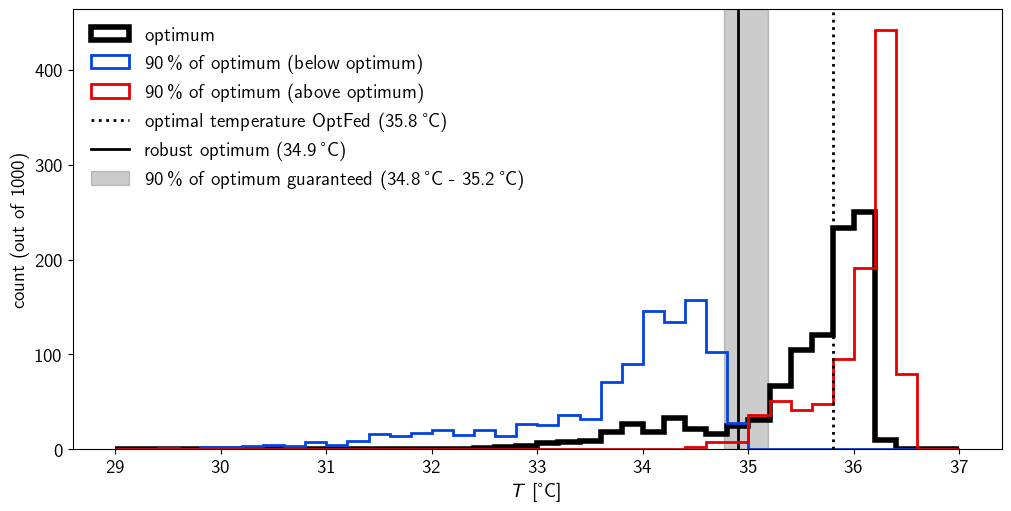

In [74]:
from pyparsing import line


fig, ax = plt.subplots(1, 1, figsize=(10, 5), layout="constrained")
r = (29, 37)
bins = 40
ax.hist(
    T_opts, bins=bins, range=r, color="k", label="optimum", histtype="step", linewidth=4
)
ax.set_xlabel("optimal temperature")
# ax1.hist(dTs75_lower, bins=100)
# ax1.set_xlim(0, None)
# ax2.hist(dTs75_upper, bins=100)
# ax2.set_xlim(0, None)
ax.hist(
    lower,
    bins=bins,
    range=r,
    label="\qty{90}{\%} of optimum (below optimum)",
    color=color_scheme.minus,
    # alpha=0.5,
    histtype="step",
    linewidth=2,
)
ax.hist(
    upper,
    bins=bins,
    range=r,
    label="\qty{90}{\%} of optimum (above optimum)",
    color=color_scheme.plus,
    # alpha=0.5,
    histtype="step",
    linewidth=2,
)
ax.set_xlabel(r"$T$ [\unit{\celsius}]")
ax.set_ylabel("count (out of 1000)")
ax.axvline(
    x=35.8,
    color="k",
    linestyle=":",
    label="optimal temperature \ourmodel (\qty{35.8}{\celsius})",
    linewidth=2,
)
ax.axvline(
    x=34.9,
    color="k",
    linestyle="-",
    label="robust optimum (\qty{34.9}{\celsius})",
    zorder=-100,
    linewidth=2,
)

r = matplotlib.patches.Rectangle(
    (34.77, 0),
    35.19 - 34.77,
    500,
    alpha=0.2,
    color="k",
    label="\qty{90}{\%} of optimum guaranteed (\qty{34.8}{\celsius} - \qty{35.2}{\celsius})",
    zorder=-10,
)
ax.add_patch(r)

# ax.axvline(
#     x=34.77,
#     color="k",
#     alpha=0.5,
#     linestyle="--",
#     label="\qty{90}{\%} of optimum guaranteed lower limit (\qty{34.8}{\celsius})",
# )
# ax.axvline(
#     x=35.19,
#     color="k",
#     alpha=0.5,
#     linestyle="--",
#     label="\qty{90}{\%} of optimum guaranteed upper limit (\qty{35.2}{\celsius})",
# )

ax.legend(frameon=False)
plt.savefig(f"{fig_path}T_opt_hist.png", bbox_inches="tight")
plt.show()

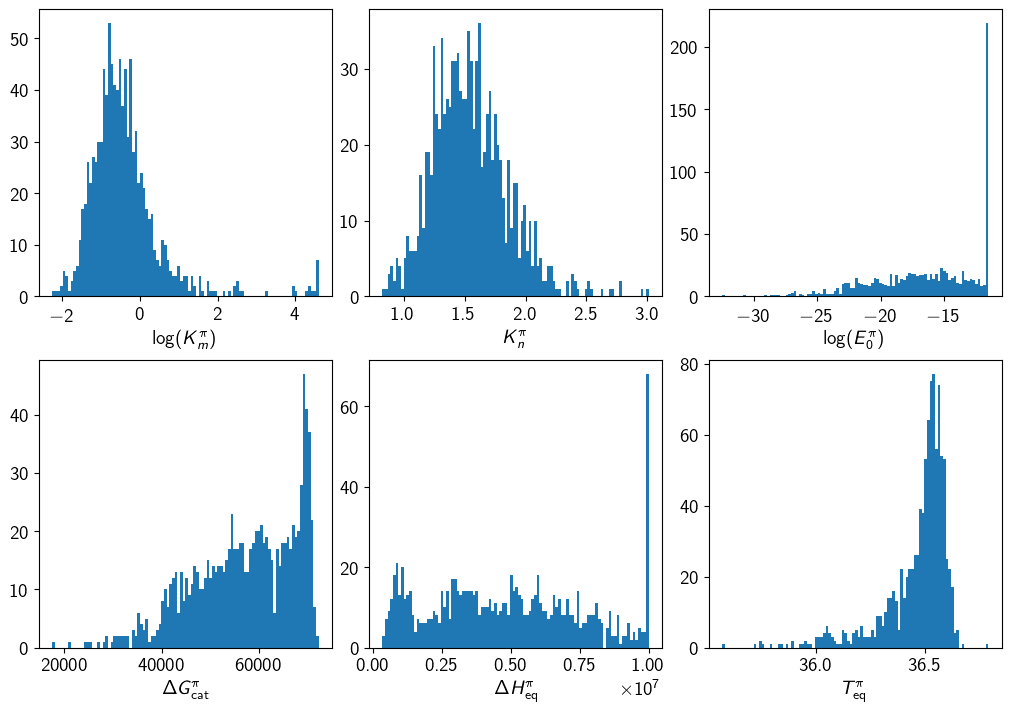

In [53]:
fig, ((ax_km, ax_kn, ax_E0), (ax_G_cat, ax_H_eq, ax_T_eq)) = plt.subplots(
    2, 3, figsize=(10, 7), layout="constrained"
)
ax_km.hist(np.log(kms), bins=100)
ax_km.set_xlabel(r"$\log(\kmgP)$")
ax_kn.hist(kns, bins=100)
ax_kn.set_xlabel(r"$\kngP$")
ax_E0.hist(np.log(E0s), bins=100)
ax_E0.set_xlabel(r"$\log(\EgP)$")
ax_G_cat.hist(G_cats, bins=100)
ax_G_cat.set_xlabel(r"$\dGgP$")
ax_H_eq.hist(H_eqs, bins=100)
ax_H_eq.set_xlabel(r"$\HeqgP$")
ax_T_eq.hist(T_eqs, bins=100)
ax_T_eq.set_xlabel(r"$\TeqgP$")
plt.show()

In [54]:
def f_opt(T):
    return -ode_gP.f_gP(1, 0, 0, 0, 0, 1, T + 273.15)


scipy.optimize.minimize(f_opt, 35, tol=1e-14)

      fun: -0.22397247193139921
 hess_inv: array([[4.9773674]])
      jac: array([-3.7252903e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 83
      nit: 8
     njev: 39
   status: 2
  success: False
        x: array([35.81018404])